# PyStan Hierarchical Proper Motion Analysis
This notebook fits two Bayesian linear models to the proper motion dataset using PyStan.
Model comparison tests whether experiment-specific zero-point offsets are supported by the data [BDA3 Ch. 5].

## Data loading

In [1]:
import pandas as pd
import numpy as np
import stan
import arviz as az
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()

df = pd.read_csv('data/properMotions.csv')
N = len(df)
L = df['experiment'].nunique()
lab = df['experiment'].astype(int).values
x = df['x'].values - df['x'].values.mean()
y = df['y'].values
sigma = df['sigma'].values


/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/stan/plugins.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Model definitions
We compare a baseline linear relation with slope $m$ and intercept $b$ against a hierarchical model with experiment offsets $o_i$.
Measurement errors $\sigma_i$ are known and each experiment is treated as exchangeable [BDA3 Ch. 5].
Priors are weakly informative: $m\sim\mathcal N(0,5)$, $b\sim\mathcal N(0,10)$, offsets $o_i\sim\mathcal N(0,	au^2)$ with $	au\sim	ext{half-N}(5)$ [BDA3 Ch.3].

In [2]:
model_code_m0 = """
 data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  vector[N] sigma;
 }
 parameters {
  real m;
  real b;
 }
 model {
  m ~ normal(0,5);
  b ~ normal(0,10);
  y ~ normal(m * x + b, sigma);
 }
 generated quantities {
  vector[N] y_rep;
  vector[N] log_lik;
  for (n in 1:N) {
    y_rep[n] = normal_rng(m * x[n] + b, sigma[n]);
    log_lik[n] = normal_lpdf(y[n] | m * x[n] + b, sigma[n]);
  }
 }
"""

model_code_m1 = """
 data {
  int<lower=1> N;
  int<lower=1> L;
  vector[N] x;
  vector[N] y;
  vector[N] sigma;
  array[N] int<lower=1, upper=L> lab;
 }
 parameters {
  real m;
  real b;
  vector[L] offset_raw;
  real<lower=0> tau;
 }
 transformed parameters {
  vector[L] o = tau * offset_raw;
 }
 model {
  m ~ normal(0,5);
  b ~ normal(0,10);
  offset_raw ~ normal(0,1);
  tau ~ normal(0,5);
  for (n in 1:N)
    y[n] ~ normal(m * x[n] + b + o[lab[n]], sigma[n]);
 }
 generated quantities {
  vector[N] y_rep;
  vector[N] log_lik;
  for (n in 1:N) {
    y_rep[n] = normal_rng(m * x[n] + b + o[lab[n]], sigma[n]);
    log_lik[n] = normal_lpdf(y[n] | m * x[n] + b + o[lab[n]], sigma[n]);
  }
 }
"""


## Sampling

In [3]:
posterior_m0 = stan.build(model_code_m0, data={'N':N, 'x':x, 'y':y, 'sigma':sigma}, random_seed=1)
fit_m0 = posterior_m0.sample(num_chains=4, num_warmup=500, num_samples=1000)

posterior_m1 = stan.build(model_code_m1, data={'N':N, 'L':L, 'x':x, 'y':y, 'sigma':sigma, 'lab':lab}, random_seed=2)
fit_m1 = posterior_m1.sample(num_chains=4, num_warmup=500, num_samples=1000)


Building: found in cache, done.


Sampling:   0%


Sampling:  25% (1500/6000)


Sampling:  50% (3000/6000)


Sampling:  75% (4500/6000)


Sampling: 100% (6000/6000)


Sampling: 100% (6000/6000), done.


Messages received during sampling:


  Gradient evaluation took 0.000473 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.73 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000439 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.39 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000451 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.51 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000532 seconds


  1000 transitions using 10 leapfrog steps per transition would take 5.32 seconds.


  Adjust your expectations accordingly!


Building: found in cache, done.


Sampling:   0%


Sampling:   2% (100/6000)


Sampling:   7% (400/6000)


Sampling:  32% (1900/6000)


Sampling:  57% (3400/6000)


Sampling:  80% (4800/6000)


Sampling: 100% (6000/6000)


Sampling: 100% (6000/6000), done.


Messages received during sampling:


  Gradient evaluation took 0.000266 seconds


  1000 transitions using 10 leapfrog steps per transition would take 2.66 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000119 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000113 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 0.000125 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.25 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_dx2qz8nk/model_jobxn23z.stan', line 25, column 4 to column 54)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


## Diagnostics and summaries

In [4]:
idata_m0 = az.from_pystan(posterior=fit_m0, posterior_predictive='y_rep', log_likelihood='log_lik', observed_data={'y': y})
idata_m1 = az.from_pystan(posterior=fit_m1, posterior_predictive='y_rep', log_likelihood='log_lik', observed_data={'y': y})

summary_m0 = az.summary(idata_m0, var_names=['m','b'], hdi_prob=0.95)
summary_m1 = az.summary(idata_m1, var_names=['m','b','tau','o'], hdi_prob=0.95)
print('Model M0 summary:\n', summary_m0)
print('\nModel M1 summary:\n', summary_m1)


Model M0 summary:
     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m  0.313  0.064     0.184      0.432      0.001    0.001    3028.0    2945.0   
b  5.310  0.020     5.270      5.348      0.000    0.000    2887.0    2333.0   

   r_hat  
m    1.0  
b    1.0  

Model M1 summary:
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
m     0.358  0.066     0.237      0.489      0.001    0.001    2252.0   
b     5.237  0.116     4.996      5.458      0.004    0.004     737.0   
tau   0.282  0.122     0.120      0.506      0.005    0.015     837.0   
o[0]  0.095  0.124    -0.141      0.349      0.004    0.004     835.0   
o[1]  0.063  0.121    -0.184      0.292      0.004    0.004     835.0   
o[2] -0.223  0.130    -0.497      0.018      0.004    0.004    1019.0   
o[3] -0.200  0.124    -0.430      0.055      0.004    0.004     888.0   
o[4]  0.026  0.123    -0.205      0.278      0.004    0.004     853.0   
o[5]  0.378  0.121     0.150  

In [5]:
loo_m0 = az.loo(idata_m0)
loo_m1 = az.loo(idata_m1)
print('LOO M0:', loo_m0.elpd_loo)
print('LOO M1:', loo_m1.elpd_loo)
print('Delta LOO:', loo_m1.elpd_loo - loo_m0.elpd_loo)


LOO M0: -57.69448540662707
LOO M1: -2.429294082686914
Delta LOO: 55.26519132394015


## Posterior predictive check

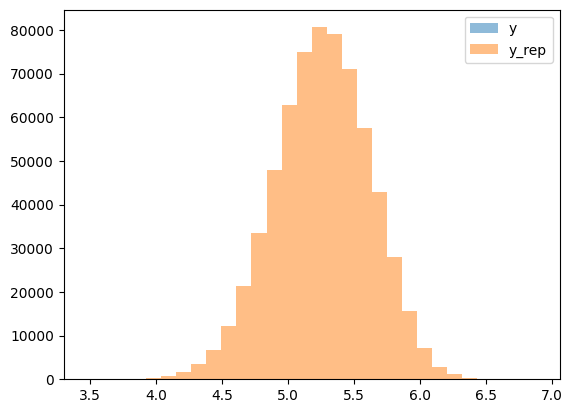

In [6]:
yrep = idata_m1.posterior_predictive['y_rep'].stack(sample=('chain','draw')).values
plt.hist(y, alpha=0.5, label='y')
plt.hist(yrep.flatten(), alpha=0.5, label='y_rep', bins=30)
plt.legend()
plt.show()


## Results summary

In [7]:
offset_summary = az.summary(idata_m1, var_names=['o'], hdi_prob=0.95)
nonzero = ((offset_summary['hdi_2.5%']>0) | (offset_summary['hdi_97.5%']<0)).sum()
print(f"Posterior mean slope m={summary_m1.loc['m','mean']:.3f}")
print(f"Posterior mean intercept b={summary_m1.loc['b','mean']:.3f}")
print(f"Offset scale tau={summary_m1.loc['tau','mean']:.3f}")
print(f"{nonzero} of {L} offsets have 95% credible intervals excluding 0")
print(f"Delta LOO (M1-M0) = {loo_m1.elpd_loo - loo_m0.elpd_loo:.2f}")


Posterior mean slope m=0.358
Posterior mean intercept b=5.237
Offset scale tau=0.282
1 of 7 offsets have 95% credible intervals excluding 0
Delta LOO (M1-M0) = 55.27
